In [22]:
from coinpp.models import ModulatedSiren
import wandb_utils
import torch
from helpers import get_datasets_and_converter
from compressai.entropy_models import EntropyBottleneck
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
import pandas as pd
from typing import Optional
import altair as alt
from evaluate import evaluate_batch
from tqdm import tqdm
import copy
from coinpp.losses import mse2psnr
from torchvision.utils import make_grid
import numpy as np
import torchvision.transforms.functional as F
import os
from climate_compression.datasets import Era5

# Initial Definitions

In [23]:
# compatibility layer to COIN++ argument parsing
class ArgsEra5():
    def __init__(self) -> None:
        self.train_dataset = "era5"
        self.test_dataset = "era5"
        self.wandb_run_path = "alconzel/coinpp-entropy/3baoe286"
        self.modulation_dataset = "modulations_train_3_steps.pt"
        self.latent_dim = 8

class ArgsCifar10():
    def __init__(self) -> None:
        self.train_dataset = "cifar10"
        self.test_dataset = "cifar10"
        self.wandb_run_path = "alconzel/coinpp-entropy/2yd2q2ew"
        self.modulation_dataset = "modulations_train_3_steps.pt"
        self.latent_dim = 512

args = ArgsEra5()
device = torch.device("cpu")
batch_size = 32

In [24]:
model, model_args, _ = wandb_utils.load_model(args.wandb_run_path, device=device)

In [12]:
# Extract dataset and create dataloader
train_dataset, test_dataset, converter = get_datasets_and_converter(
    args, force_no_random_crop=True
)
num_pixels = math.prod(train_dataset[0].shape)
num_train_samples = len(train_dataset)
max_train_iterations = math.ceil(num_train_samples/batch_size)
num_test_samples = len(test_dataset)

In [13]:
class LatentDataset(Dataset):
    def __init__(self, latents) -> None:
        self.latents = latents
    
    def __getitem__(self, idx):
        return self.latents[idx, :]
    
    def __len__(self):
        return self.latents.shape[0]

In [14]:
# this does not actually load the modulations, but the latents!
latents = wandb_utils.load_modulations(
    args.wandb_run_path, args.modulation_dataset, device
)
latent_dataset = LatentDataset(latents)
latent_dataloader = DataLoader(latent_dataset, shuffle=False, batch_size=batch_size)
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
test_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)

# samples to play around with
for l in latent_dataloader:
    latent_0 = l
    break

for d in train_dataloader:
    data_0 = d
    break

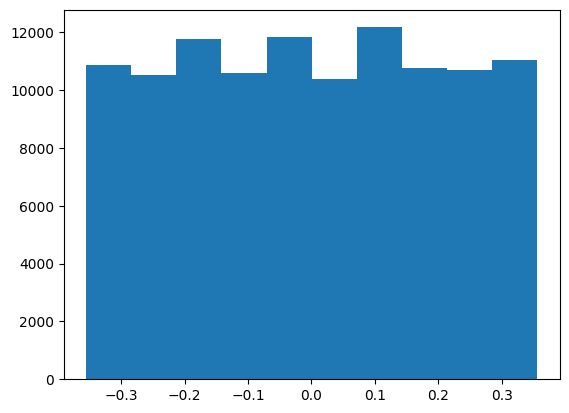

In [15]:
plt.hist(model.modulation_net(latent_0).detach().flatten())
plt.show()

## Inspecting the dataset
The description given in the original paper (Generative models as distributions of functions):

> We extracted the data used for the climate experiments from the ERA5 database (Hersbach et al., 2019). Specifically, we used the monthly averaged surface temperature at 2m, with reanalysis by hour of day. Each data point then corresponds to a set of temperature measurements on a 721 x 1440 grid (i.e. 721 latitudes and 1440 longitudes) across the entire globe (corresponding to measurements every 0.25 degrees). For our experiments, we subsample this grid by a factor of 16 to obtain grids of size 46 x 90. For each month, there are a total of 24 grids, corresponding to each hour of the day. The dataset is then composed of temperature measurements for all months between January 1979 and December 2020, for a total of 12096 datapoints. We randomly split this dataset into a train set containing 8510 grids, a validation set containing 1166 grids and a test set containing 2420 grids. Finally, we normalize the data to lie in [0, 1] with the lowest temperature recorded since 1979 corresponding to 0 and the highest temperature to 1.

This means, the dataset consists of 
$T(h, m, y) = \sum_{d} T(h, d, m, y)$.

We expect, that the average over days takes out some variability of the data. We expect, that the data is roughly the same every year, so we essentially only have $24 * 12 = 288$ data points.

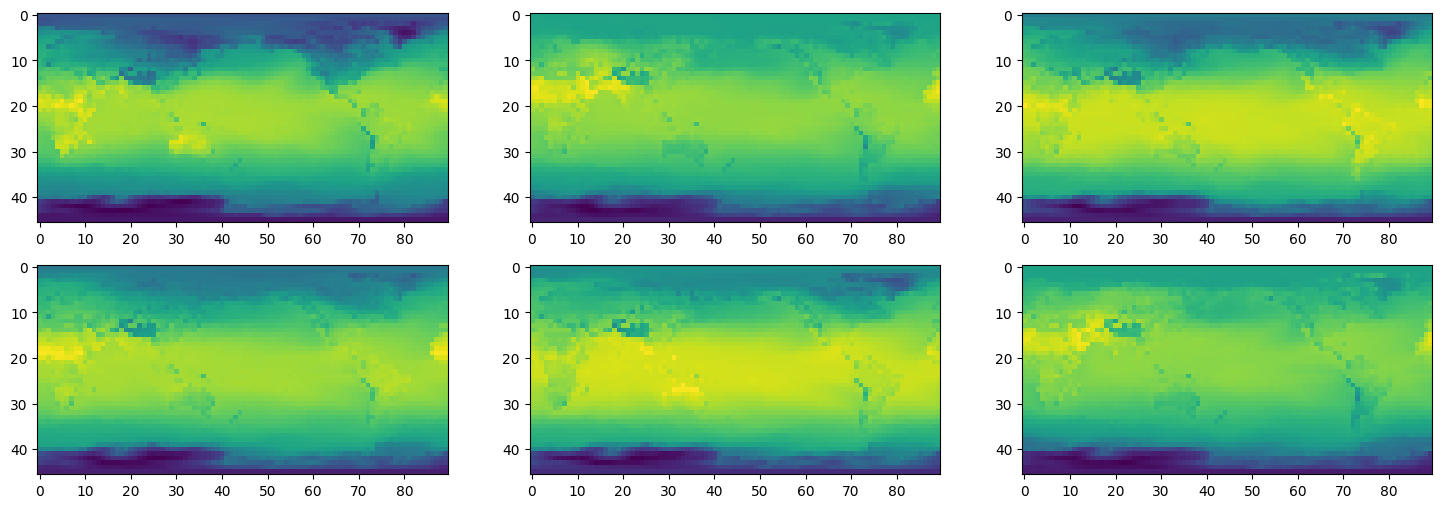

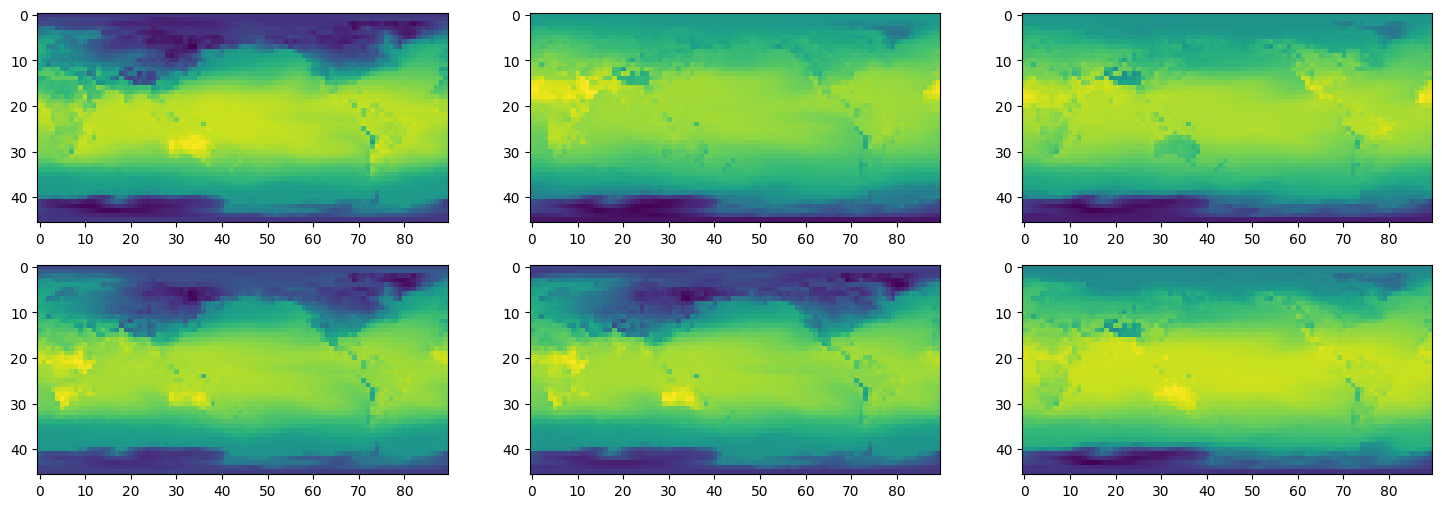

In [17]:
torch.manual_seed(0)
inspection_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)
def show_dataset(dataset):
    i = 0
    inspect_set = []
    for dat in dataset:
        i+=1
        inspect_set.append(dat.squeeze())
        if i > 12:
            break
        if i % 6 == 0:
            f, axarr = plt.subplots(2,3, figsize=(18,6))
            axarr[0,0].imshow(inspect_set[0])
            axarr[0,1].imshow(inspect_set[1])
            axarr[1,0].imshow(inspect_set[2])
            axarr[1,1].imshow(inspect_set[3])
            axarr[0,2].imshow(inspect_set[4])
            axarr[1,2].imshow(inspect_set[5])
            inspect_set = []
            plt.show()
show_dataset(inspection_dataloader)

If we compare this to the dataset that we use:

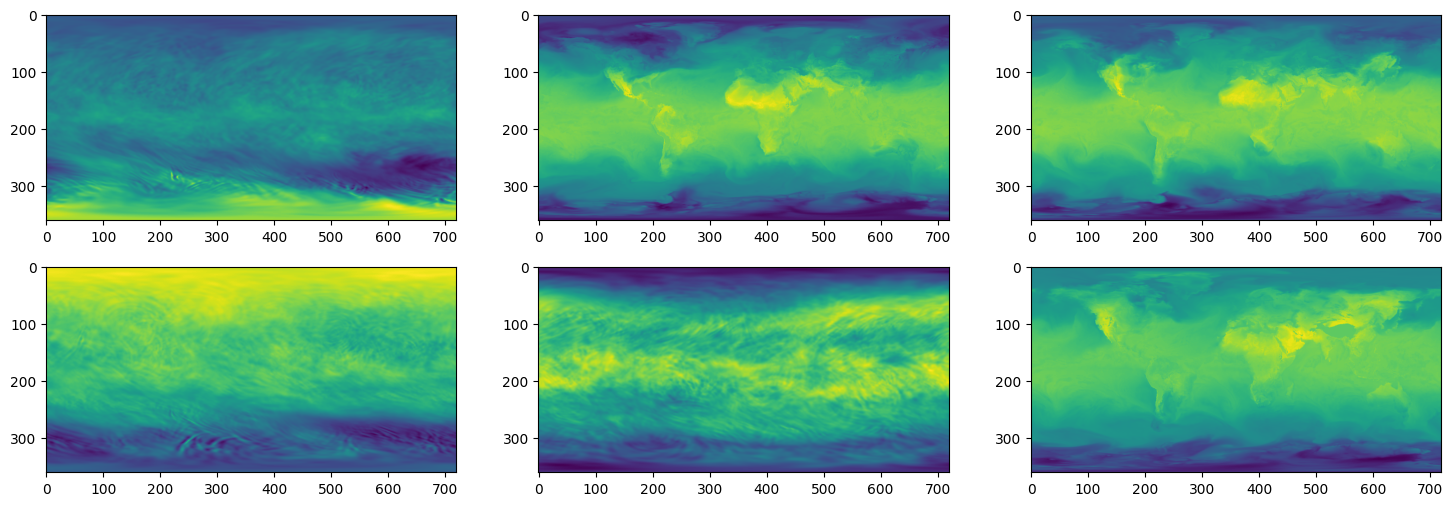

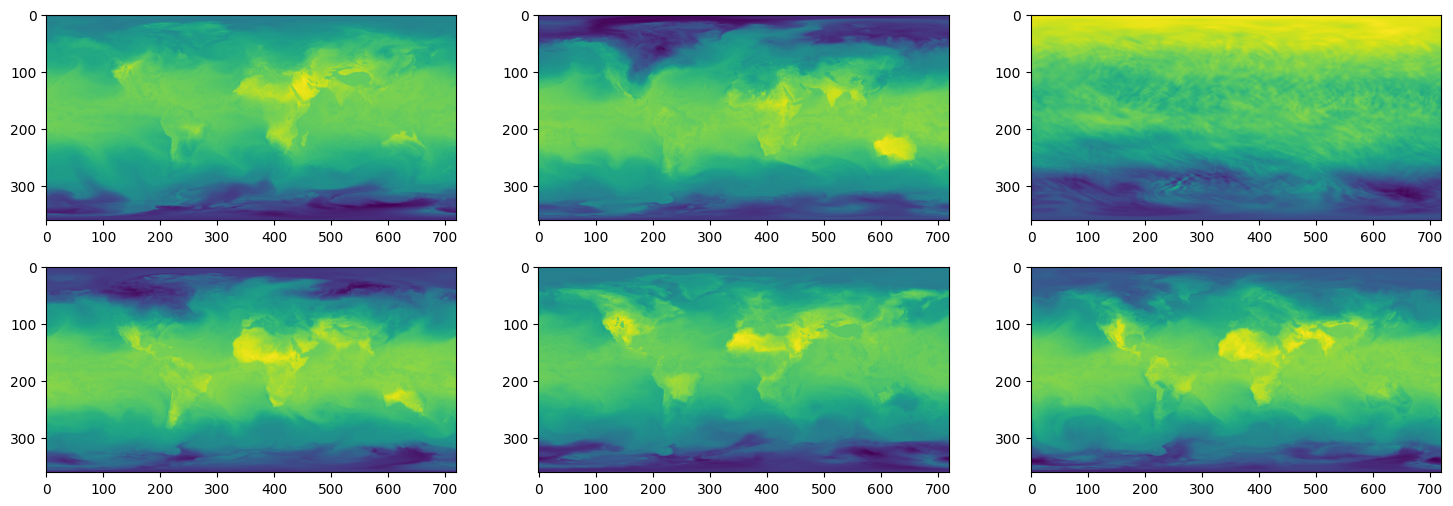

In [21]:
sample_path = os.path.expanduser("~/datasets/era5_temperatures_2008.nc")
our_inspection_set = Era5(sample_path, "t")
our_dataloader = DataLoader(our_inspection_set, shuffle=True, batch_size=1)
show_dataset(our_dataloader)

# Training a single entropy bottleneck

## Training code

In [7]:
def train_bottleneck(bottleneck, gamma: float = 1.0, log=1, num_epochs: int = 5):
    bottleneck_optimiser = torch.optim.Adam(bottleneck.parameters(), lr=1e-3)
    bottleneck.train()
    res = []

    for i in tqdm(range(num_epochs)):
        aux_loss = torch.Tensor(0)
        bpp_loss = torch.Tensor(0)
        for batch in latent_dataloader:
            bottleneck_optimiser.zero_grad()
            latent_discretised, likelihood = bottleneck(batch * gamma)
            bpp_loss = torch.sum(- torch.log(likelihood) / math.log(2))  / num_pixels
            aux_loss = bottleneck.loss()
            aux_loss.backward()
            bpp_loss.backward()
            bottleneck_optimiser.step()

        if log >= 1:
            with torch.no_grad():
                bottleneck.train(False)
                epoch_result = evaluate_bottleneck(bottleneck, latent_0, data_0, gamma)
                epoch_result["epoch"] = i
                epoch_result["aux_loss"] = aux_loss
                bottleneck.train(True)
                res.append(epoch_result)
                if log == 2:
                    print(epoch_result)
                
    bottleneck.train(False)
    bottleneck.update()

    return pd.DataFrame(res) if log >= 1 else None

def evaluate_bottleneck(bottleneck, latent, data, gamma: float = 1.0, update: bool = True):
    assert not bottleneck.training, "Model must be in eval."
    if update:
        bottleneck.update()
    l_disc, ll = bottleneck(latent * gamma)
    mse, psnr = evaluate_batch(model, converter, l_disc/gamma, data)
    bpp_loss = torch.sum(- torch.log(ll) / math.log(2))  / num_pixels
    
    return {"bpp_loss": bpp_loss.detach().item(), "mse": mse, "psnr": psnr}

def loader_by_kind(kind: str):
    if kind == "train":
        dataloader = train_dataloader
        num_samples = num_train_samples
    elif kind == "test":
        dataloader = test_dataloader
        num_samples = num_test_samples
    else: 
        raise ValueError("Unknown kind: " + kind)
    return dataloader, num_samples

def evaluate_bottleneck_full(bottleneck, gamma: float = 1.0, iterations_max: Optional[int] = None, kind="train"):
    assert not bottleneck.training, "Model must be in eval."
    bottleneck.update()
    idx = 0
    results = {}
    n = 0  
    dataloader, _ = loader_by_kind(kind)
    num_samples = 0

    for d in tqdm(dataloader, total=iterations_max):
        if iterations_max is not None and n >= iterations_max: 
            break
        batch_size = d.shape[0]
        n += 1
        num_samples += batch_size 
        latent = latents[idx : (idx + batch_size)]
        idx += batch_size
        res = evaluate_bottleneck(bottleneck, latent, d, gamma, update=False)

        for key, val in res.items():
            val_n = val * batch_size
            if key not in results:
                results[key] = val_n
            else:
                results[key] += val_n
    return {key: val / num_samples for key, val in results.items()}
    
def evaluate_coinpp(nbits: int, kind="train"):
    dataloader, _ = loader_by_kind(kind)
    modulation_dataset = f"modulations_train_3_steps_{nbits}_bits_dequantized.pt"

    latents = wandb_utils.load_modulations(
        args.wandb_run_path, modulation_dataset, device
    )
    latent_dataset = LatentDataset(latents)
    latent_dataloader = DataLoader(latent_dataset, shuffle=False, batch_size=32)

    for l in latent_dataloader:
        for d in dataloader:
            mse, psnr = evaluate_batch(model, converter, l, d)
            break
        break
    bpp = nbits * latents.shape[1] / num_pixels # type: ignore
    return {"mse": mse, "psnr": psnr, "bpp": bpp, "nbits": nbits} #type: ignore
        

## Evaluating the training for an example bottleneck

In [8]:
entropy_bottleneck = EntropyBottleneck(args.latent_dim)
entropy_bottleneck.update()
initial_cdf = entropy_bottleneck.quantized_cdf.clone() # type: ignore

In [9]:
res = train_bottleneck(entropy_bottleneck, log=1)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


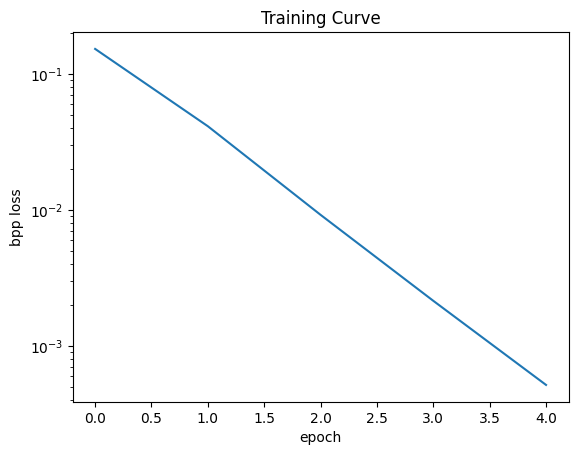

In [10]:
assert res is not None
plt.plot(res.epoch, res.bpp_loss)
plt.yscale("log")
plt.ylabel("bpp loss")
plt.xlabel("epoch")
plt.title("Training Curve")
plt.show();

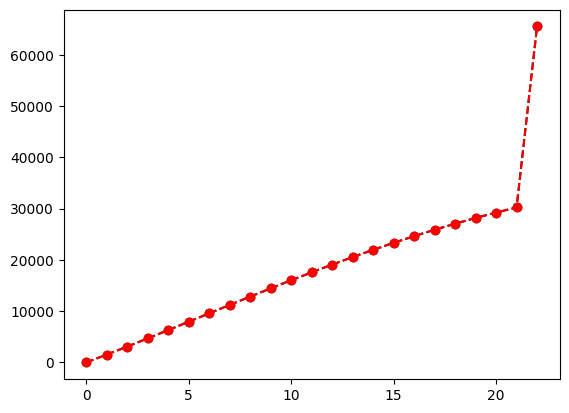

In [11]:
channel = 0
entropy_bottleneck.update()
entropy_bottleneck.train(False)
plt.plot(entropy_bottleneck.quantized_cdf[channel,:], "--ko") # type: ignore
plt.plot(initial_cdf[channel,:], "--ro") # type: ignore
plt.show()

In [12]:
entropy_bottleneck(latents[None, 180, :]) # type: ignore

(tensor([[-0.0026, -0.0239,  0.0068,  0.0242,  0.0035,  0.0124, -0.0076,  0.0065]],
        grad_fn=<PermuteBackward0>),
 tensor([[0.9943, 0.9942, 0.9942, 0.9941, 0.9943, 0.9943, 0.9943, 0.9942]],
        grad_fn=<PermuteBackward0>))

## Sanity tests

In [13]:
l = latents[None, 0, :] #type: ignore
x = train_dataset[0]
c, f = converter.to_coordinates_and_features(x)

((model.modulated_forward(c, l) - f)**2).mean()

tensor(0.0004, grad_fn=<MeanBackward0>)

In [14]:
# Sanity tests

evaluate_batch(model, converter, latent_0, data_0) #type: ignore

(0.0003575176524464041, 34.474403381347656)

## Evaluating the Entropy Bottleneck solution
The naive try should be really bad, as the latents are small.

In [15]:
l_disc_0, ll = entropy_bottleneck(latent_0)
evaluate_batch(model, converter, l_disc_0, data_0)

(0.0265379436314106, 15.779489517211914)

We now vary the scaling of the latent modulation.

In [16]:
gammas = [0.1, 1, 5, 10, 20, 50, 100, 1000, 5000, 10_000]
dfs = []
bottlenecks = {}

for gamma in gammas:
    bottleneck_gamma = EntropyBottleneck(args.latent_dim)
    res = train_bottleneck(bottleneck_gamma, gamma, log=1)
    assert res is not None
    res["gamma"] = gamma
    dfs.append(res)

    bottleneck_gamma.train(False)
    bottlenecks[gamma] = bottleneck_gamma
gamma_df = pd.concat(dfs)

100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


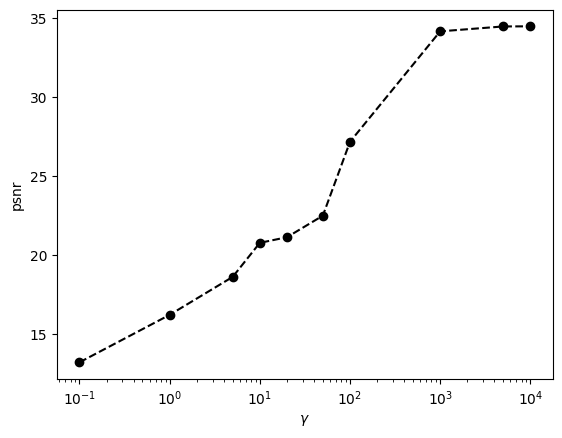

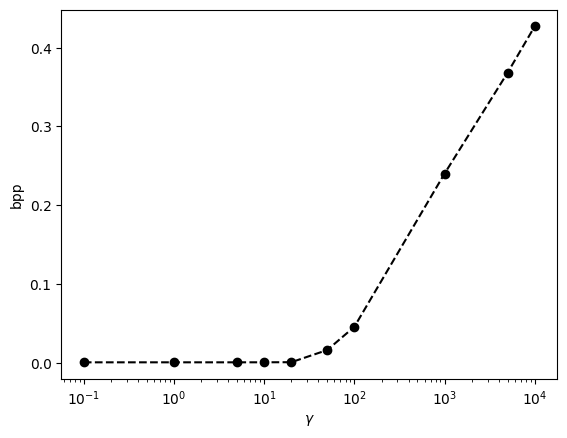

In [17]:
gamma_df_last = gamma_df[gamma_df.epoch == gamma_df.epoch.max()]
plt.plot(gamma_df_last.gamma, gamma_df_last.psnr, "--ko")
plt.xscale("log")
plt.xlabel("$\gamma$")
plt.ylabel("psnr")
plt.show()

plt.plot(gamma_df_last.gamma, gamma_df_last.bpp_loss, "--ko")
plt.xscale("log")
plt.xlabel("$\gamma$")
plt.ylabel("bpp")
plt.show()

## RD-Curves vs COIN++

In [18]:
coinpp_results = []
coinpp_bits = [2,3,4,5,6,7,8,9,10,16,32]
for bits in coinpp_bits:
    coinpp_results.append(evaluate_coinpp(bits))
coinpp_df = pd.DataFrame(coinpp_results)

In [19]:
coinpp_df = pd.DataFrame(coinpp_results)
coinpp_df

,mse,psnr,bpp,nbits
0,0.001696,27.747202,0.003865,2
1,0.000528,32.806755,0.005797,3
2,0.000405,33.939308,0.007729,4
3,0.000368,34.350304,0.009662,5
4,0.000360,34.449875,0.011594,6
5,0.000358,34.463879,0.013527,7
6,0.000358,34.471565,0.015459,8
7,0.000358,34.473969,0.017391,9
8,0.000358,34.474319,0.019324,10
9,0.000358,34.474411,0.030918,16


In [20]:
entropy_bottleneck_full_results = []
for gamma in gammas:
    res = evaluate_bottleneck_full(bottlenecks[gamma], gamma, iterations_max=1, kind="train")
    res["gamma"] = gamma
    entropy_bottleneck_full_results.append(res)

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [21]:
entropy_bottleneck_full_df = pd.DataFrame(entropy_bottleneck_full_results)
entropy_bottleneck_full_df

,bpp_loss,mse,psnr,gamma
0,0.000507,0.047645,13.224372,0.1
1,0.000515,0.023908,16.225386,1.0
2,0.000507,0.013735,18.624846,5.0
3,0.000549,0.008364,20.779955,10.0
4,0.000659,0.007706,21.135292,20.0
5,0.016093,0.006401,22.498310,50.0
6,0.045639,0.001976,27.169836,100.0
7,0.240103,0.000385,34.155006,1000.0
8,0.368193,0.000358,34.464691,5000.0
9,0.427134,0.000358,34.472790,10000.0


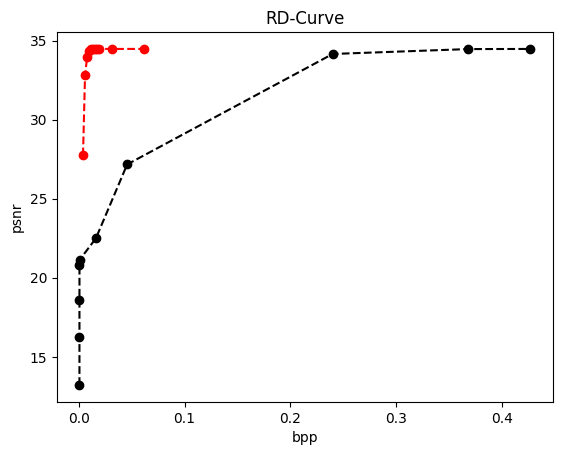

In [22]:
plt.plot(entropy_bottleneck_full_df.bpp_loss, entropy_bottleneck_full_df.psnr, "--ko")
plt.plot(coinpp_df.bpp, coinpp_df.psnr, "--ro")
plt.title("RD-Curve")
plt.xlabel("bpp")
plt.ylabel("psnr");

## Inspections

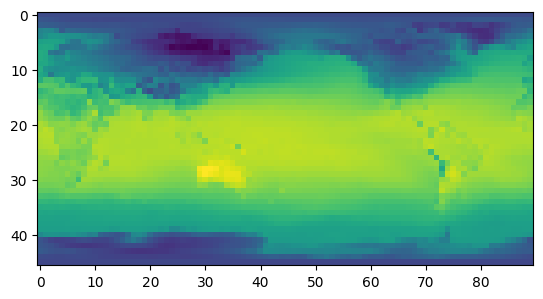

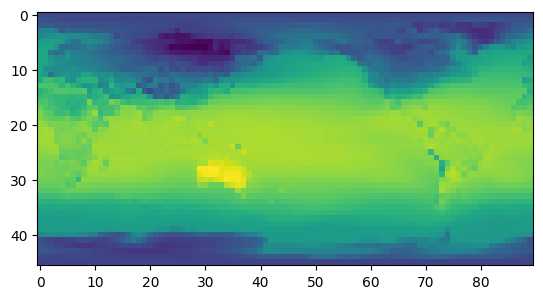

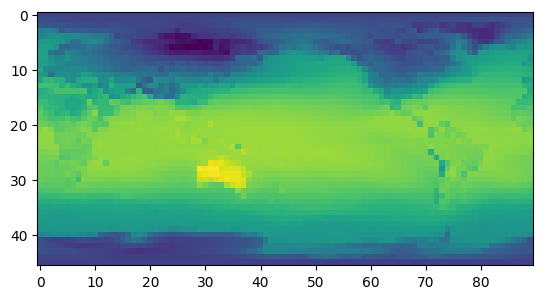

In [23]:
for i in range(3):
    im = torch.permute(data_0[i, :, :, :], (1,2,0))
    plt.imshow(im)
    plt.show()

In [24]:
i = 0
for l in latent_dataloader:
    print(f"Latent {i}\n", l[:3, :])
    lat, ll = bottlenecks[10_000](l * 10_000)
    print(f"Latent {i} disc.\n", lat[:3, :] / 10_000)
    i += 1
    if i >= 3:
        break

Latent 0
 tensor([[ 0.0041, -0.0004, -0.0007,  0.0014,  0.0004, -0.0015,  0.0041,  0.0046],
        [ 0.0042, -0.0006, -0.0007,  0.0015,  0.0001, -0.0013,  0.0042,  0.0045],
        [ 0.0045, -0.0010, -0.0007,  0.0020, -0.0006, -0.0003,  0.0042,  0.0038]])
Latent 0 disc.
 tensor([[ 4.1235e-03, -3.7698e-04, -7.0538e-04,  1.3338e-03,  3.6994e-04,
         -1.4772e-03,  4.1140e-03,  4.5875e-03],
        [ 4.2235e-03, -5.7698e-04, -7.0538e-04,  1.4338e-03,  6.9943e-05,
         -1.3772e-03,  4.2140e-03,  4.4875e-03],
        [ 4.5235e-03, -1.0770e-03, -6.0538e-04,  2.0338e-03, -6.3006e-04,
         -2.7722e-04,  4.2140e-03,  3.7875e-03]], grad_fn=<DivBackward0>)
Latent 1
 tensor([[ 0.0037, -0.0003, -0.0022,  0.0013,  0.0001, -0.0032,  0.0020,  0.0021],
        [-0.0007, -0.0002, -0.0018,  0.0018, -0.0004, -0.0023,  0.0002,  0.0013],
        [-0.0007, -0.0004, -0.0017,  0.0019, -0.0007, -0.0022,  0.0002,  0.0012]])
Latent 1 disc.
 tensor([[ 3.7235e-03, -2.7698e-04, -2.2054e-03,  1.3338e-03,

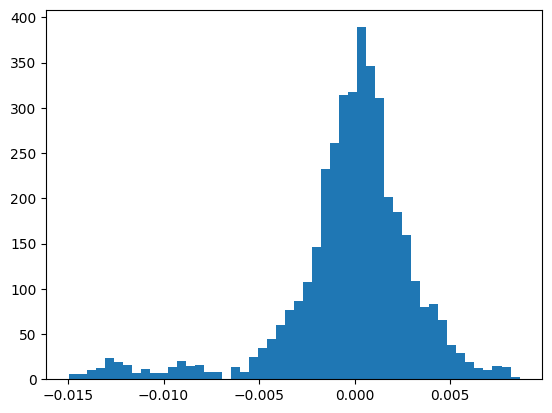

In [25]:
plt.hist(latents[:500,:].flatten(), bins=50)
plt.show()

# Training latents with bottleneck
We have seen that the performance of our method does not reach the same level as the quantised latents. We wonder if we can fix this by learning the modulations together with the entropy bottleneck.

In [26]:
def train_bottleneck_with_latents(train_bottleneck, train_latents, num_epochs, beta, train_gamma: int, log: int = 1, num_batches: int = 1):
    train_bottleneck.train(True)
    latent_optimiser = torch.optim.Adam([train_latents], lr=1e-3)
    bottleneck_optimiser = torch.optim.Adam(train_bottleneck.parameters(), lr=1e-3)
    train_bottleneck.train()

    res = []

    for epoch in range(num_epochs):
        i = 0
        latent_idx = 0

        for d in train_dataloader:
            if i >= num_batches:
                break
            data_size = d.shape[0]
            if log >= 1:
                print(f"Epoch: {epoch+1}/{num_epochs}, Batch {i+1}/{num_batches}")

            l = train_latents[latent_idx : latent_idx + data_size, :]

            bottleneck_optimiser.zero_grad()
            latent_optimiser.zero_grad()

            l_disc, likelihood = train_bottleneck(l * train_gamma)

            bpp_loss = torch.sum(- torch.log(likelihood) / math.log(2))  / num_pixels

            # calc MSE
            coordinates, features = converter.to_coordinates_and_features(d)
            features_recon = model.modulated_forward(coordinates, l_disc)
            mse_loss = torch.nn.MSELoss()(features_recon, features)

            loss = mse_loss + beta * bpp_loss
            aux_loss = train_bottleneck.loss()

            aux_loss.backward()
            loss.backward()
            bottleneck_optimiser.step()
            latent_optimiser.step()

            if log >= 1:
                with torch.no_grad():
                    psnr = mse2psnr(mse_loss).item()
                epoch_result = {"mse": mse_loss.item(), "bpp_loss": bpp_loss.item(), "loss": loss.item(), "psnr": psnr, "aux_loss": aux_loss.item(), "epoch": epoch, "batch": i}
                res.append(epoch_result)
                if log == 2:
                    print(epoch_result)
            
            i += 1
            latent_idx += data_size
                
    train_bottleneck.train(False)
    train_bottleneck.update()

    return pd.DataFrame(res) #if log >= 1 else None


In [27]:
train_gamma = 100
num_epochs = 5
beta_bottleneck_results = []
train_results = []

for beta in [0.01, 0.1, 1.0, 10.0, 100]:
    print(f"Beta: {beta}")
    train_bottleneck = copy.deepcopy(bottlenecks[train_gamma])
    trainable_latents = torch.nn.Parameter(latents.clone(), requires_grad=True)
    train_res = train_bottleneck_with_latents(train_bottleneck, trainable_latents, train_gamma=train_gamma, num_epochs=num_epochs, beta=beta, log=2)
    train_bottleneck.train(False)
    res = evaluate_bottleneck(train_bottleneck, trainable_latents[0, :][None, :], data_0, gamma=train_gamma)
    res["beta"] = beta
    train_res["beta"] = beta
    beta_bottleneck_results.append(res)
    train_results.append(train_res)
beta_df = pd.DataFrame(beta_bottleneck_results)

Beta: 0.01
Epoch: 1/5, Batch 1/1
{'mse': 0.04913974925875664, 'bpp_loss': 0.06453857570886612, 'loss': 0.04978513345122337, 'psnr': 13.085670471191406, 'aux_loss': 91.17066192626953, 'epoch': 0, 'batch': 0}
Epoch: 2/5, Batch 1/1
{'mse': 0.04726574569940567, 'bpp_loss': 0.0625024288892746, 'loss': 0.04789077118039131, 'psnr': 13.254535675048828, 'aux_loss': 90.87639617919922, 'epoch': 1, 'batch': 0}
Epoch: 3/5, Batch 1/1
{'mse': 0.0458863228559494, 'bpp_loss': 0.06376268714666367, 'loss': 0.04652395099401474, 'psnr': 13.38316822052002, 'aux_loss': 90.82723999023438, 'epoch': 2, 'batch': 0}
Epoch: 4/5, Batch 1/1
{'mse': 0.04688320681452751, 'bpp_loss': 0.06666303426027298, 'loss': 0.047549836337566376, 'psnr': 13.289827346801758, 'aux_loss': 90.81263732910156, 'epoch': 3, 'batch': 0}
Epoch: 5/5, Batch 1/1
{'mse': 0.04589562490582466, 'bpp_loss': 0.07550226897001266, 'loss': 0.04665064811706543, 'psnr': 13.38228702545166, 'aux_loss': 90.77643585205078, 'epoch': 4, 'batch': 0}
Beta: 0.1
Ep

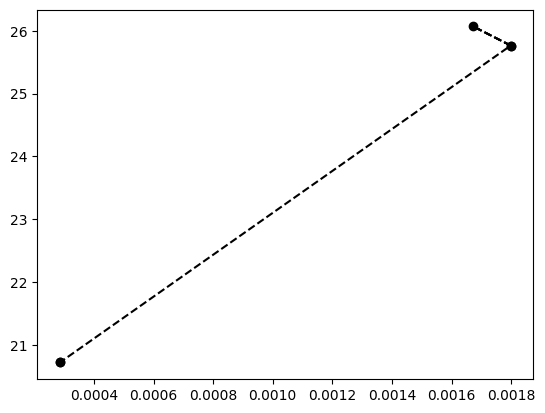

In [28]:
plt.plot(beta_df.bpp_loss, beta_df.psnr, "--ko")

In [29]:
beta_df

,bpp_loss,mse,psnr,beta
0,0.001799,0.002781,25.764202,0.01
1,0.001673,0.002648,26.067448,0.10
2,0.001799,0.002781,25.764254,1.00
3,0.000286,0.008483,20.719904,10.00
4,0.000286,0.008483,20.719902,100.00
